<a href="https://colab.research.google.com/github/shikharmay7/DiabeticRetinopathy/blob/master/DRGradingv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
train_df = pd.read_csv('/content/drive/My Drive/Datasets/regular-fundus-training/regular-fundus-training.csv')
val_df = pd.read_csv('/content/drive/My Drive/Datasets/regular-fundus-validation/regular-fundus-validation.csv')

In [4]:
print("train data : ",train_df.shape)
print("Validation data : ",val_df.shape)

train data :  (1200, 10)
Validation data :  (400, 10)


In [0]:
image_id = train_df['image_id']
patient_id = train_df['patient_id']
image_path = train_df['image_path']
left_dr = train_df['left_eye_DR_Level']
right_dr = train_df['right_eye_DR_Level']

In [0]:
train=[]
train_y=[]
for i in range(train_df.shape[0]):
  imgPath = "/content/drive/My Drive/Datasets/regular-fundus-training/"+str(patient_id[i])+"/" + str(image_id[i])+".jpg"
  train.append(imgPath)
  if(i%4==0 or i%4==1):
    train_y.append(left_dr[i])
  else:
    train_y.append(right_dr[i])

In [0]:
vimage_id = val_df['image_id']
vpatient_id = val_df['patient_id']
vimage_path = val_df['image_path']
vleft_dr = val_df['left_eye_DR_Level']
vright_dr = val_df['right_eye_DR_Level']

In [0]:
val=[]
val_y=[]
for i in range(val_df.shape[0]):
  imgPath = "/content/drive/My Drive/Datasets/regular-fundus-validation/"+str(vpatient_id[i])+"/" + str(vimage_id[i])+".jpg"
  val.append(imgPath)
  if(i%4==0 or i%4==1):
    val_y.append(vleft_dr[i])
  else:
    val_y.append(vright_dr[i])

Training data available in 5 classes
[540, 140, 234, 214, 72]


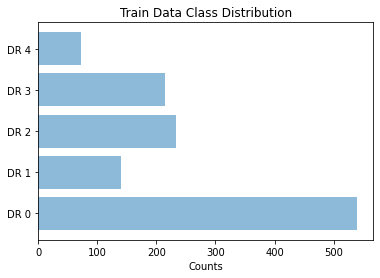

In [10]:
print("Training data available in 5 classes")
print([train_y.count(i) for i in range(5)])
 
DR_classes = ('DR 0','DR 1','DR 2', 'DR 3', 'DR 4')
 
y_pos = np.arange(len(DR_classes))
counts = [train_y.count(i) for i in range(5)]
 
plt.barh(y_pos, counts, align='center', alpha=0.5)
plt.yticks(y_pos, DR_classes)
plt.xlabel('Counts')
plt.title('Train Data Class Distribution')
plt.show()

In [14]:
# Importing Keras libraries
from keras.utils import np_utils
from keras.models import Sequential
from keras.applications import VGG16, ResNet50
from keras.applications import imagenet_utils
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, GlobalAveragePooling2D

Using TensorFlow backend.


In [0]:
def show_imgs(X):
    plt.figure(figsize=(8, 8))
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            image = load_img(X[k], target_size=(224, 224))
            plt.subplot2grid((4,4),(i,j))
            plt.imshow(image)
            k = k+1
    # show the plot
    plt.show()

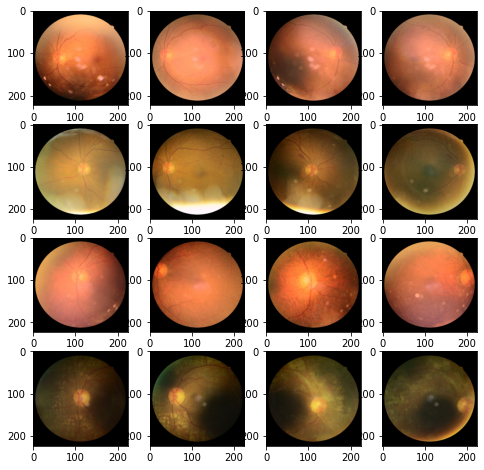

In [16]:
show_imgs(train)

In [0]:
import cv2
img_row = 224
img_col = 224

In [0]:
def show_pre_process(X):
  plt.figure(figsize=(8,8))
  k=0
  for i in range(4):
    for j in range(4):
      image = cv2.imread(train[k])
      image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      image = cv2.resize(image,(img_row,img_col))
      image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , img_row/10) ,-4 ,128)
      plt.subplot2grid((4,4), (i,j))
      plt.imshow(image, cmap='gray')
      k=k+1
  plt.show()

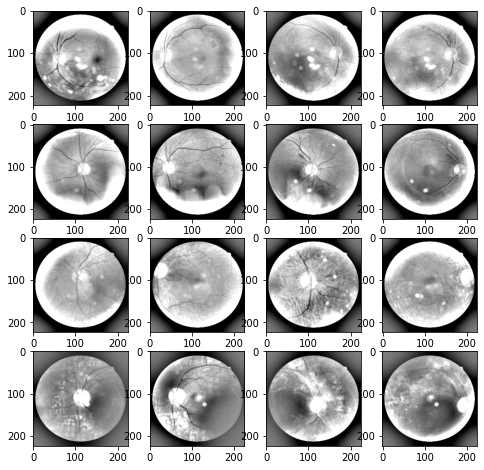

In [27]:
show_pre_process(train)

In [0]:
def crop_image_gray(img,tol=7):
  if img.ndim == 2:
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]
  elif img.ndim == 3:
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    mask = gray_img>tol
    check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
    if check_shape == 0:
      return img
    else:
      img1 = img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
      img2 = img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
      img3 = img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
      img = np.stack([img1,img2,img3], axis=-1)
    return img

In [0]:
def show_pre_process2(X):
  plt.figure(figsize=(8,8))
  k=0
  for i in range(4):
    for j in range(4):
      image = cv2.imread(X[k])
      image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      image = cv2.resize(image,(img_row,img_col))
      image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , img_row/10) ,-4 ,128)
      image = crop_image_gray(image,7)
      plt.subplot2grid((4,4), (i,j))
      plt.imshow(image, cmap='gray')
      k=k+1
  plt.show()

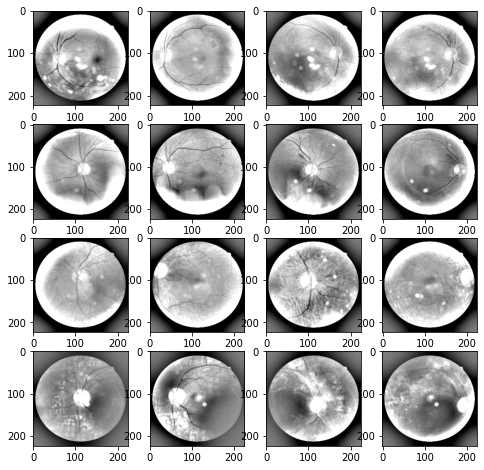

In [35]:
show_pre_process2(train)

In [0]:
def load_ben_color(path, sigmaX=10):
  image = cv2.imread(path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = crop_image_gray(image)
  image = cv2.resize(image, (img_row,img_col))
  image = cv2.addWeighted(image,4, 
          cv2.GaussianBlur(image, (0,0), sigmaX), -4, 128)
  return image


In [0]:
def show_pre_process3(X):
  plt.figure(figsize=(8,8))
  k=0
  for i in range(4):
    for j in range(4):
      image = load_ben_color(X[k],10)
      plt.subplot2grid((4,4), (i,j))
      plt.imshow(image, cmap='gray')
      k=k+1
  plt.show()

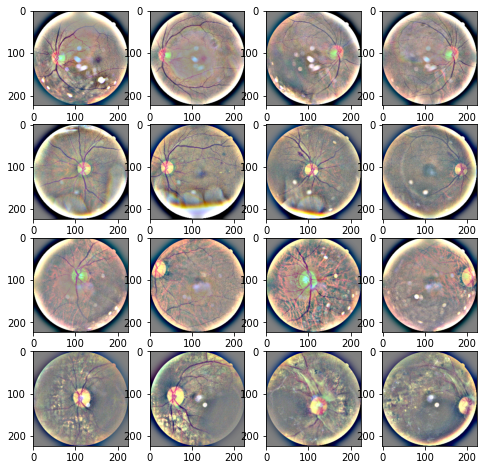

In [45]:
show_pre_process3(train)

In [46]:
model1 = VGG16(weights="imagenet", include_top=False)
model1.summary()

58892288/58889256 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [52]:
img1 = load_ben_color(train[0])
print(img1.shape)
img1 = img_to_array(img1)
img1 = np.expand_dims(img1, axis=0)
img1 = imagenet_utils.preprocess_input(img1)
pred1 = model1.predict(img1)
print(pred1.shape)

(224, 224, 3)
(1, 7, 7, 512)


In [0]:
def create_features(dataset, pre_model):
  x_scratch=[]

  for imPath in dataset:
    image = load_ben_color(imPath)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = imagenet_utils.preprocess_input(image)
    x_scratch.append(image)

  x = np.vstack(x_scratch)
  features = pre_model.predict(x,batch_size=32)
  features_flatten = features.reshape((features.shape[0], 7*7*512))

  return x, features, features_flatten

In [55]:
train_x, train_features, train_features_flatten = create_features(train, model1)
val_x, val_features, val_features_flatten = create_features(val, model1)

print(train_x.shape, train_features.shape, train_features_flatten.shape)
print(val_x.shape, val_features.shape, val_features_flatten.shape)



(1200, 224, 224, 3) (1200, 7, 7, 512) (1200, 25088)
(400, 224, 224, 3) (400, 7, 7, 512) (400, 25088)


In [56]:
import sklearn
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(train_features_flatten, train_y)

y_pred_train = rf.predict(train_features_flatten)
y_pred_val = rf.predict(val_features_flatten)

print("Training Metrices:")
print(sklearn.metrics.classification_report(y_true=train_y,
                                            y_pred=y_pred_train))

print("Validation Metrices:")
print(sklearn.metrics.classification_report(y_true=val_y,
                                            y_pred=y_pred_val))

Training Metrices:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       540
         1.0       1.00      1.00      1.00       140
         2.0       1.00      1.00      1.00       234
         3.0       1.00      1.00      1.00       214
         4.0       1.00      1.00      1.00        72

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200

Validation Metrices:
              precision    recall  f1-score   support

         0.0       0.52      0.96      0.68       174
         1.0       0.00      0.00      0.00        46
         2.0       0.49      0.20      0.28        92
         3.0       0.72      0.43      0.54        68
         4.0       0.00      0.00      0.00        20

    accuracy                           0.54       400
   macro avg       0.35      0.32      0.30       400
weighted avg       0.46      0.54    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [57]:


#Creating Quadratic Weighted Kappa Metric
from sklearn.metrics import confusion_matrix

actual_val = val_y
pred_val = y_pred_val

type(pred_val)
pred_val_list=[]
for i in range(pred_val.shape[0]):
  pred_val_list.append(pred_val[i])

O = confusion_matrix(actual_val, pred_val)
# pred_val.shape[0]
O



array([[167,   2,   3,   2,   0],
       [ 40,   0,   5,   1,   0],
       [ 69,   1,  18,   4,   0],
       [ 31,   0,   8,  29,   0],
       [ 13,   0,   3,   4,   0]])

In [58]:
#Step 2: Weighted Matrix
W = np.zeros((5,5))
for i in range(len(W)):
  for j in range(len(W)):
    W[i][j] = float(((i-j)**2)/16)
W

array([[0.    , 0.0625, 0.25  , 0.5625, 1.    ],
       [0.0625, 0.    , 0.0625, 0.25  , 0.5625],
       [0.25  , 0.0625, 0.    , 0.0625, 0.25  ],
       [0.5625, 0.25  , 0.0625, 0.    , 0.0625],
       [1.    , 0.5625, 0.25  , 0.0625, 0.    ]])

In [59]:
#Step 3: Histogram
n=5
# act_val_hist = np.zeros([n])
# pred_val_hist = np.zeros([n])

# for item in actual_val:
#   act_val_hist[item]+=1
# for item in pred_val:
#   pred_val_hist[item]+=1
act_val_hist = [actual_val.count(i) for i in range(n)]
pred_val_hist = [pred_val_list.count(i) for i in range(n)]

print(f'Actual validation freq: {act_val_hist} Predicted Validation freq: {pred_val_hist}' )

Actual validation freq: [174, 46, 92, 68, 20] Predicted Validation freq: [320, 3, 37, 40, 0]


In [60]:


#Step 4: Expected Value (Outer Product of histogram)
E = np.outer(act_val_hist, pred_val_hist)
E



array([[55680,   522,  6438,  6960,     0],
       [14720,   138,  1702,  1840,     0],
       [29440,   276,  3404,  3680,     0],
       [21760,   204,  2516,  2720,     0],
       [ 6400,    60,   740,   800,     0]])

In [0]:
#Step 5: Normalize E and O matrix
E = E/E.sum()
O = O/O.sum()
# E.sum()

In [0]:
#Step 6: Weighted Kappa Calculation
def weighted_kappa(W,O,E,n):
  num=0
  den=0
  for i in range(n):
    for j in range(n):
      num+=W[i][j]*O[i][j]
      den+=W[i][j]*E[i][j]
  
  kappa = (1-(num/den))
  return kappa

In [63]:
weighted_kappa(W,O,E,n)

0.3536732533260287